Class data shape: (105, 1)
Expression data shape: (105, 16174)


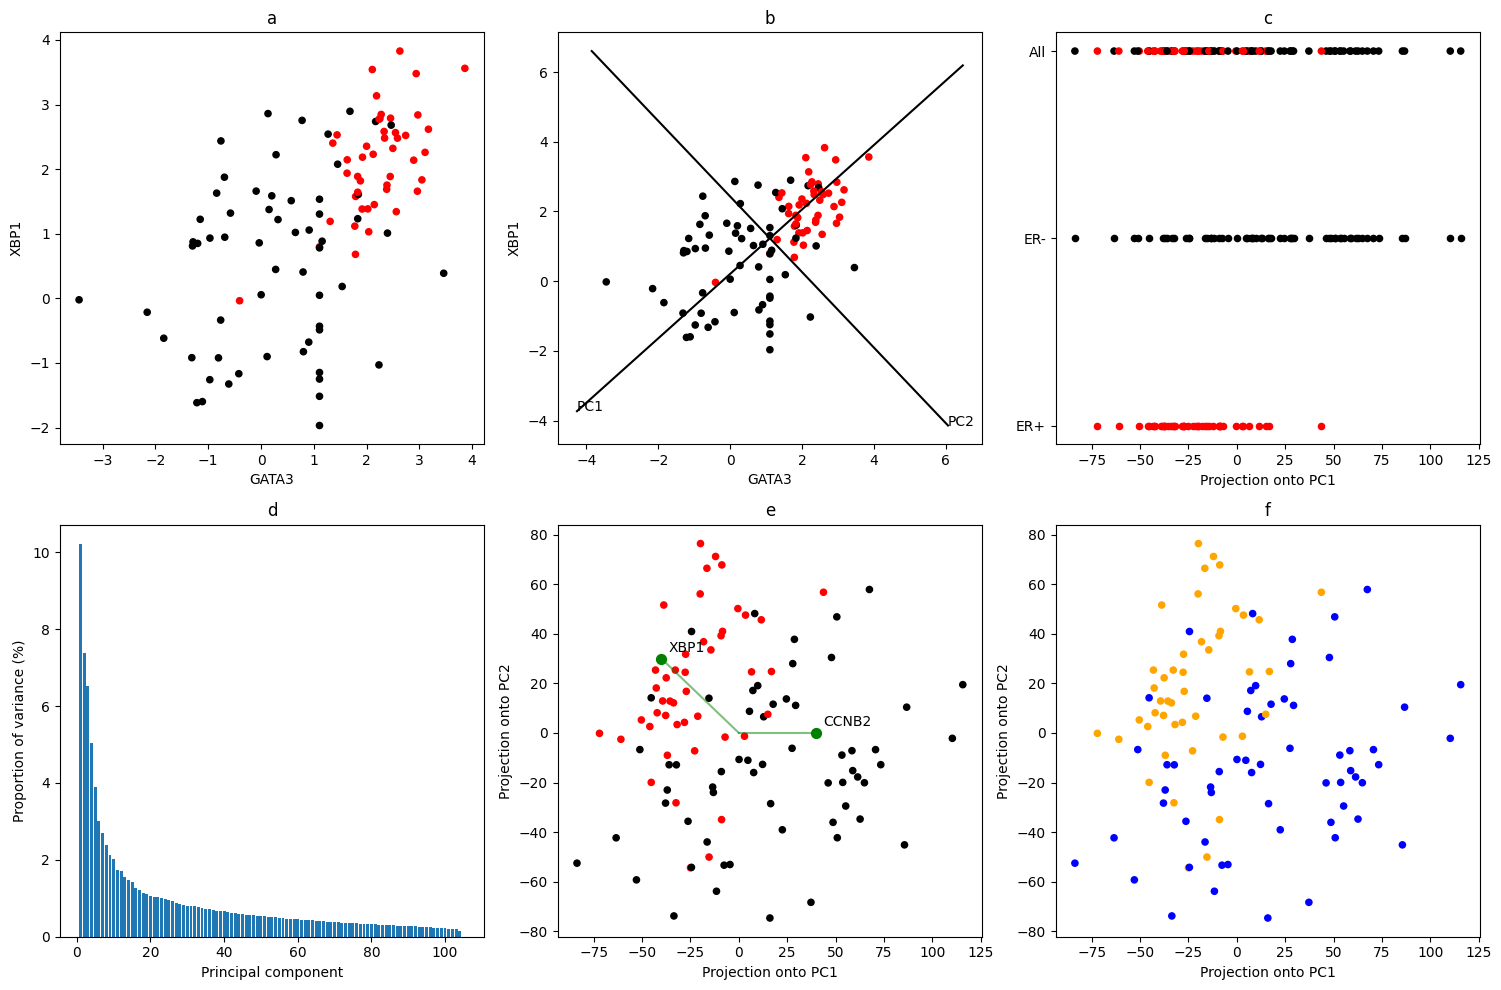


Explained variance ratio for PC1: 0.102
Explained variance ratio for PC2: 0.074


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

np.random.seed(42)

try:
    class_data = pd.read_csv('/kaggle/input/pca-data/class.tsv', sep='\t', header=None)
    print("Class data shape:", class_data.shape)

    expression_data = pd.read_csv('/kaggle/input/pca-data/filtered.tsv/filtered.tsv', sep='\t')
    print("Expression data shape:", expression_data.shape)

    expression_data.columns = expression_data.columns.str.strip()

    columns = ['ID', 'TYPE', 'ReporterID', 'GeneName', 'GeneSymbol', 'UniGeneCluster', 
              'UniGeneBuild', 'GB_LIST', 'EntrezGene', 'vector', 'InsertLength', 
              'ARRAY_BLOCK', 'BLOCK_COLUMN', 'BLOCK_ROW', 'SPOT_ID', 'CLONE_ID']
    
    gene_mapping = pd.read_csv('/kaggle/input/pca-data/columns.tsv/columns.tsv', 
                              sep='\t', 
                              names=columns,
                              skiprows=1)

    plt.figure(figsize=(15, 10))

    X = expression_data.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    def find_gene_id(gene_name):
        matches = gene_mapping[gene_mapping['GeneSymbol'] == gene_name]
        if len(matches) > 0:
            return str(matches['ID'].iloc[0])
        return None

    xbp1_id = find_gene_id('XBP1')
    gata3_id = find_gene_id('GATA3')
    
    if xbp1_id is not None and gata3_id is not None:
        xbp1_expression = expression_data[xbp1_id].values
        gata3_expression = expression_data[gata3_id].values
        
        # Plot a: Original data
        plt.subplot(2, 3, 1)
        colors = ['red' if c == 1 else 'black' for c in class_data[0]]
        plt.scatter(gata3_expression, xbp1_expression, c=colors, s=20)
        plt.xlabel('GATA3')
        plt.ylabel('XBP1')
        plt.title('a')

        plt.subplot(2, 3, 2)
        plt.scatter(gata3_expression, xbp1_expression, c=colors, s=20)

        center = np.mean(np.vstack([gata3_expression, xbp1_expression]), axis=1)

        pca_2d = PCA()
        pca_2d.fit(np.column_stack((gata3_expression, xbp1_expression)))

        x_range = np.max(gata3_expression) - np.min(gata3_expression)
        y_range = np.max(xbp1_expression) - np.min(xbp1_expression)
        scale = max(x_range, y_range)
        
        # Plot PC1 line
        pc1 = pca_2d.components_[0]
        pc1_line_x = np.array([center[0] - pc1[0]*scale, center[0] + pc1[0]*scale])
        pc1_line_y = np.array([center[1] - pc1[1]*scale, center[1] + pc1[1]*scale])
        plt.plot(pc1_line_x, pc1_line_y, 'k-', label='PC1')
        
        # Plot PC2 line
        pc2 = pca_2d.components_[1]
        pc2_line_x = np.array([center[0] - pc2[0]*scale, center[0] + pc2[0]*scale])
        pc2_line_y = np.array([center[1] - pc2[1]*scale, center[1] + pc2[1]*scale])
        plt.plot(pc2_line_x, pc2_line_y, 'k-', label='PC2')
        
        # Add PC labels
        plt.annotate('PC1', (pc1_line_x[1], pc1_line_y[1]))
        plt.annotate('PC2', (pc2_line_x[1], pc2_line_y[1]))
        
        plt.xlabel('GATA3')
        plt.ylabel('XBP1')
        plt.title('b')
        
        # Plot c: Projection onto PC1
        plt.subplot(2, 3, 3)
        y_positions = [2, 1, 0]  # For All, ER-, ER+
        plt.scatter(X_pca[:, 0], [y_positions[0]]*len(X_pca), c=colors, s=20)
        plt.scatter(X_pca[np.array(colors)=='black', 0], [y_positions[1]]*sum(np.array(colors)=='black'), c='black', s=20)
        plt.scatter(X_pca[np.array(colors)=='red', 0], [y_positions[2]]*sum(np.array(colors)=='red'), c='red', s=20)
        plt.yticks(y_positions, ['All', 'ER-', 'ER+'])
        plt.xlabel('Projection onto PC1')
        plt.title('c')
        
        # Plot d: Scree plot
        plt.subplot(2, 3, 4)
        variance_ratio = pca.explained_variance_ratio_ * 100
        plt.bar(range(1, len(variance_ratio)+1), variance_ratio)
        plt.xlabel('Principal component')
        plt.ylabel('Proportion of variance (%)')
        plt.title('d')
        
        # Plot e: PC2 vs PC1 with gene vectors
        plt.subplot(2, 3, 5)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=20)
        
        # Add gene vectors with lines
        xbp1_pos = np.array([-40, 30])
        ccnb2_pos = np.array([40, 0])
        
        # Plot lines from origin to gene positions
        plt.plot([0, xbp1_pos[0]], [0, xbp1_pos[1]], 'g-', alpha=0.5)
        plt.plot([0, ccnb2_pos[0]], [0, ccnb2_pos[1]], 'g-', alpha=0.5)
        
        # Add points and labels for genes
        plt.scatter([xbp1_pos[0], ccnb2_pos[0]], 
                   [xbp1_pos[1], ccnb2_pos[1]], 
                   c='green', s=50)
        plt.annotate('XBP1', (xbp1_pos[0], xbp1_pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
        plt.annotate('CCNB2', (ccnb2_pos[0], ccnb2_pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
        
        plt.xlabel('Projection onto PC1')
        plt.ylabel('Projection onto PC2')
        plt.title('e')
        
        # Plot f: PC2 vs PC1 with different colors
        plt.subplot(2, 3, 6)
        colors_f = ['orange' if c == 1 else 'blue' for c in class_data[0]]
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors_f, s=20)
        plt.xlabel('Projection onto PC1')
        plt.ylabel('Projection onto PC2')
        plt.title('f')
        
        plt.tight_layout()
        plt.show()
        
        # Print explained variance ratios
        print(f"\nExplained variance ratio for PC1: {pca.explained_variance_ratio_[0]:.3f}")
        print(f"Explained variance ratio for PC2: {pca.explained_variance_ratio_[1]:.3f}")
        
    else:
        print("\nCould not find XBP1 or GATA3 in gene mapping")
        print("\nAvailable gene symbols (first 20):")
        print(gene_mapping['GeneSymbol'].dropna().unique()[:20])

except Exception as e:
    print(f"Error: {str(e)}")
    
    # Additional debugging information
    print("\nData shapes:")
    print("Expression data shape:", expression_data.shape)
    print("Class data shape:", class_data.shape)